In [1]:
%matplotlib notebook
import sys
from pathlib import Path

SRC_ROOT_DIR_0 = '/g/wsl_projs/practical-astronomy'
SRC_ROOT_DIR_1 = '/g/wsl_projs/practical-astronomy/myastro/'
sys.path.insert(0, SRC_ROOT_DIR_0)
sys.path.insert(1, SRC_ROOT_DIR_1)

%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from myastro.ephem import calc_orbits_data, EphemrisInput
from myastro.data_catalog import DF_BODYS, DF_COMETS, read_body_elms_for, read_comet_elms_for, CometElms, BodyElems
from myastro.data_catalog import APOFIS
import seaborn as sns
from toolz import concat, first
from myastro.graphics_util import OrbitsPlot


ModuleNotFoundError: No module named 'myastro.ephem'

In [62]:
eph = EphemrisInput(from_date="1972.02.01.0",
                    to_date = "1992.05.01.0",
                    step_dd_hh_hhh = "50 00.0",
                    equinox_name = "J2000")

#PLANETS = ['Earth','Mercury','Venus','Mars']
#PLANETS = ['Jupiter','Saturn','Uranus','Neptune', 'Pluto']
PLANETS = ['Jupiter']
#PLANETS = []
#PLANETS = ['Jupiter','Saturn']
#MINOR_BODYS = []
#MINOR_BODYS = ['Ceres','Pallas','Juno','Vesta']
#MINOR_BODYS = ['Ceres',APOFIS]
#MINOR_BODYS = ['Ceres']
#MINOR_BODYS = []
MINOR_BODYS=[]
#COMETS = ['1P/Halley','2P/Encke','10P/Tempel 2','C/1995 O1 (Hale-Bopp)']
COMETS = ['C/2019 Q4 (Borisov)']
#COMETS = ['D/1993 F2-A (Shoemaker-Levy 9)']
COMETS = ['C/1988 L1 (Shoemaker-Holt-Rodriquez)'] #, 'C/1980 E1 (Bowell)','C/2019 Q4 (Borisov)']
COMETS = ['C/1980 E1 (Bowell)','C/2019 Q4 (Borisov)']
#COMETS = []

orbs, dfs, date_refs = calc_orbits_data(eph, PLANETS, MINOR_BODYS, COMETS)

Calculating data for  Jupiter
Calculating data for  C/1980 E1 (Bowell)


/g/wsl_projs/practical-astronomy/myastro/orbit.py:715: RuntimeWarning: invalid value encountered in sqrt
  e_sinE = h_xyz.dot(h_vxyz)/sqrt(GM*a)
/g/wsl_projs/practical-astronomy/myastro/data_catalog.py:47: RuntimeWarning: invalid value encountered in sqrt
  self.period_in_days = TWOPI*sqrt(pow(self.a,3)/GM)


Calculating data for  C/2019 Q4 (Borisov)


### Other implementation

In [4]:
dfs.append(calc_eph_minor_body_perturbed(APOFIS,eph))

In [21]:
CERES = read_body_elms_for("Ceres",DF_BODYS)
dfs.append(calc_eph_minor_body_perturbed(CERES,eph))


In [5]:
#HALLEY = read_comet_elms_for("1P/Halley",DF_COMETS)
#ENCKE = read_comet_elms_for("2P/Encke",DF_COMETS)
HALLEY = CometElms(name="1P/Halley",
            epoch_mjd=None ,
            q =  0.5870992 ,
            e = 0.9672725 ,
            i_dg = 162.23932 ,
            Node_dg = 58.14397 ,
            w_dg = 111.84658 ,
            tp_str = "19860209.44",
            equinox_name = "B1950")

ENCKE = CometElms(name="2P/Encke",
        epoch_mjd=None ,
        q =  2.2091404*(1-0.8502196) ,
        e = 0.8502196 ,
        i_dg = 11.94524 ,
        Node_dg = 334.75006 ,
        w_dg = 186.23352 ,
        tp_str = "19901028.54502",
        equinox_name = "J2000")     


comets = [HALLEY,ENCKE]
for comet in comets:
    dfs.append(calc_eph_comet(comet,eph))


<IPython.core.display.Javascript object>


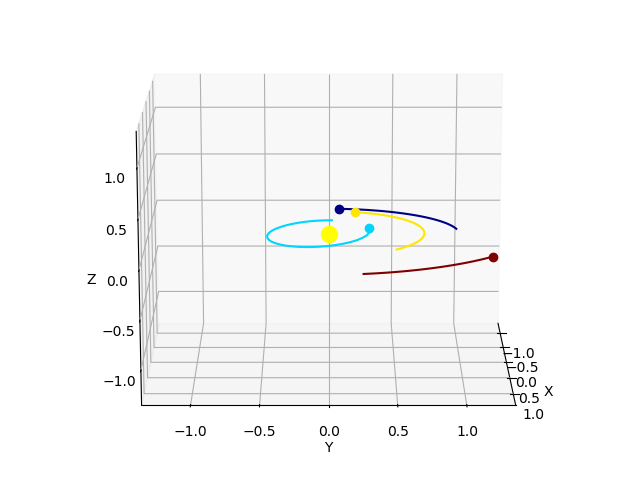

In [8]:
cols=['h_x','h_y','h_z']
# A 3d matrix with shape (a,b,c) where a=n_orbits, b=n_t_samples, c=3
x_t = np.array([df[cols].to_numpy() for df in dfs])

N_trajectories = len(dfs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c) for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c) for c in colors], [])

LIMITS=(-1.3,1.3)

# prepare the axes limits
#ax.set_xlim((-30,30 ))
#ax.set_ylim((-30,30))
#ax.set_zlim((-30, 30))
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(15, 0)
# SUN
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    #print (i)
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        #print (x)
        #print (y)
        #print (z)
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=500, interval=500, blit=True, repeat=False)
#anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)

# Save as mp4. This requires mplayer or ffmpeg to be installed
#anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()


In [25]:
animate(2)

[-0.18314445 -0.21738337 -0.25134806 -0.28499862]
[-0.37991948 -0.39134127 -0.39518683 -0.39197985]
[0.5200483  0.49103405 0.46048123 0.42848397]
[1.37965144 1.3754605  1.37068102 1.36531696]


In [4]:
#animate (3)
len(orbs)

2

### Next Implementation

<IPython.core.display.Javascript object>


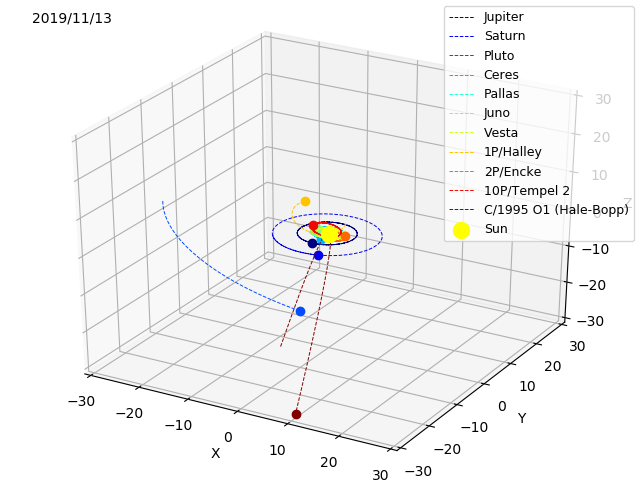

In [5]:
n_trajectories = len(orbs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

lines = []
pts = []
for i, (name, mtx) in enumerate(orbs.items()):
    lines.append(ax.plot([], [], [], '--', c=colors[i], label=name,lw=.7))
    pts.append(ax.plot([], [], [], 'o', c=colors[i]))
    #ax.plot3D(mtx[:,0],mtx[:,1],mtx[:,2], c=colors[i], lw=.75, label=name)
lines = list(concat(lines))
pts = list(concat(pts))

#LIMITS=(-1.3,1.3)
LIMITS=(-30,30)
# prepare the axes limits
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# SUN
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

#   set the legend, title and animation encoding type
ax.legend(loc='upper right', prop={'size': 9})
#ax.set_title("Tim-Sitze, Orbits of the Inner Planets")
#animation.writer = animation.writers['ffmpeg']

axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, date_refs[0], ha="left", va="top")

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

def animate(i):
    for line, pt, mtx in zip(lines, pts, orbs.values()):
        xs = mtx[0:i,0]        
        ys = mtx[0:i,1]
        zs = mtx[0:i,2]
        line.set_data(xs, ys)
        line.set_3d_properties(zs)
        
        x = xs[-1:]
        y = ys[-1:]
        z = zs[-1:]        
        pt.set_data(x, y)
        pt.set_3d_properties(z)
        
        time.set_text(date_refs[i])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts
    
# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(date_refs), interval=1000, blit=False, repeat=False)
plt.show()

In [15]:
animate(4)

[2.07666195 2.09028128 2.10388254 2.11746558]
[-6.24950665 -6.24143339 -6.23335255 -6.22526413]


### Current Implementation

<IPython.core.display.Javascript object>


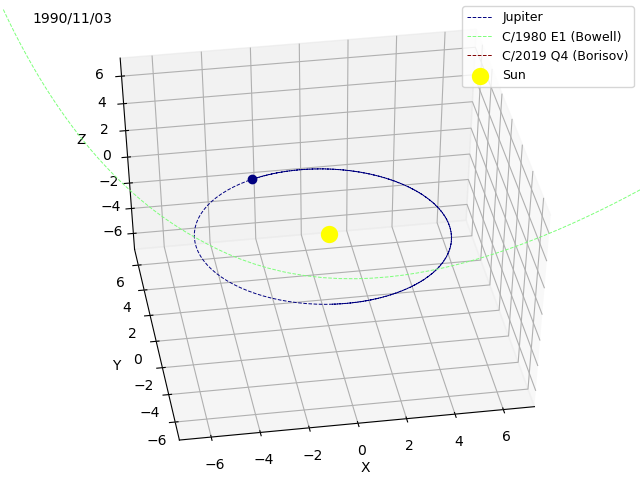

In [63]:
fig = plt.figure()
LIMITS=(-7,7)
orbs_plot = OrbitsPlot(orbs, date_refs, fig, LIMITS)
anim = animation.FuncAnimation(fig, orbs_plot.animate, init_func=orbs_plot.init, frames=len(date_refs), interval=1000, blit=False, repeat=False)
plt.show()


In [25]:
df = DF_COMETS

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633 entries, 0 to 3632
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    3633 non-null   object 
 1   Epoch   3633 non-null   float64
 2   q       3633 non-null   float64
 3   e       3633 non-null   float64
 4   i       3633 non-null   float64
 5   w       3633 non-null   float64
 6   Node    3633 non-null   float64
 7   Tp      3633 non-null   object 
 8   Ref     3633 non-null   object 
dtypes: float64(6), object(3)
memory usage: 255.6+ KB


In [29]:
df.sort_values('e',ascending=False)[:3]

,Name,Epoch,q,e,i,w,Node,Tp,Ref
3591,C/2019 Q4 (Borisov),59061.0,2.006624,3.356191,44.05263,209.12461,308.14892,20191208.54489,JPL 52
3632,C/2020 J1 (SONEAR),58972.0,3.207467,1.063884,142.17320,344.64352,227.81652,20210407.54326,JPL 1
1075,C/1980 E1 (Bowell),44972.0,3.363938,1.057732,1.66171,135.08262,114.55820,19820312.28714,JPL 5


<IPython.core.display.Javascript object>


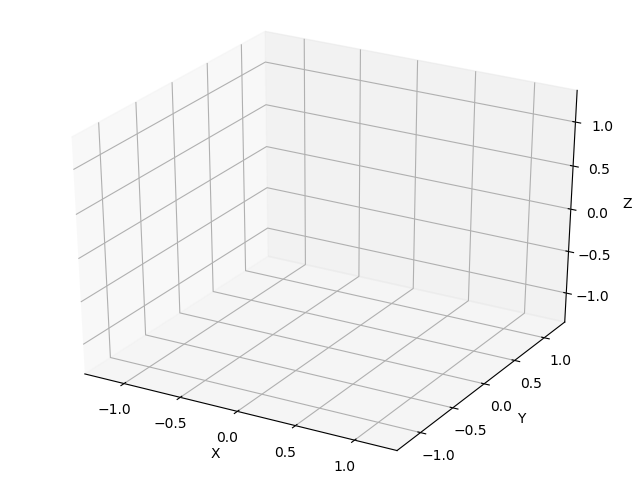

In [9]:
# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))


In [10]:
colors

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.15882353, 1.        , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [0.49019608, 1.        , 0.47754586, 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [1.        , 0.27668845, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [11]:
lines = []
pts = []
for i, (name, mtx) in enumerate(orbs.items()):
    lines.append(ax.plot([], [], [], '-', c=colors[i],label=name))
    pts.append(ax.plot([], [], [], 'o', c=colors[i]))
    #ax.plot3D(mtx[:,0],mtx[:,1],mtx[:,2], c=colors[i], lw=.75, label=name)
lines = list(concat(lines))
pts = list(concat(pts))
    
    

In [12]:
LIMITS=(-1.3,1.3)
# prepare the axes limits
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

Text(0.0863224683098014, 0.011565017836136133, 'Z')

In [13]:
# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts


In [14]:
def animate(i):
    for line, pt, mtx in zip(lines, points, orbs.values()):
        xs = mtx[0:i,0]
        ys = mtx[0:i,1]
        zs = mtx[0:i,2]
        line.set_data(xs, ys)
        line.set_3d_properties(zs)

        x = xs[-1:]
        y = ys[-1:]
        z = zs[-1:]
        pt.set_data(x, y)
        pt.set_3d_properties(z)

        #ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts


In [15]:
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)



In [16]:
plt.show()

In [80]:
i=3
xyz[0:i,0] #  x
xs =  xyz[0:i,0] 

In [81]:
xs[-1:]

array([7])

In [78]:
xs

array([1, 4])

In [17]:
# first plot the constants to be used in our plots
# plot the sun at the origin
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# plot the orbit of mercury
ax.plot3D(merc_orb[:,0],merc_orb[:,1],merc_orb[:,2], color='gray', lw=.75, label='Mercury')

# plot the prbit of Venus
ax.plot3D(ven_orb[:,0],ven_orb[:,1],ven_orb[:,2], color='orange', lw=.75, label='Venus')

# plot the orbit of the Earth
ax.plot3D(earth_orb[:,0],earth_orb[:,1],earth_orb[:,2], color='blue', lw=.75, label='Earth')

# plot the orbit of Mars
ax.plot3D(mars_orb[:,0],mars_orb[:,1],mars_orb[:,2], color='red', lw=.75, label='Mars')


# get the particles 3d plots. Initially empty
merc_particle, = plt.plot([],[],[], marker='.', color='gray', lw=2)
ven_particle, = plt.plot([],[],[], marker='.', color='orange', lw=2)
earth_particle, = plt.plot([],[],[], marker='.', color='blue', lw=2)
mars_particle, = plt.plot([],[],[], marker='.', color='red', lw=2)

In [18]:
lines

In [ ]:
cols=['h_x','h_y','h_z']
# A 3d matrix with shape (a,b,c) where a=n_orbits, b=n_t_samples, c=3
x_t = np.array([df[cols].to_numpy() for df in dfs])

N_trajectories = len(dfs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

LIMITS=(-1.3,1.3)

# prepare the axes limits
#ax.set_xlim((-30,30 ))
#ax.set_ylim((-30,30))
#ax.set_zlim((-30, 30))
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(15, 0)
# SUN
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=500, interval=500, blit=True, repeat=False)
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)

# Save as mp4. This requires mplayer or ffmpeg to be installed
#anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()


In [20]:
list1=['a','b','c']
sum(list1,[''])

TypeError: can only concatenate list (not "str") to list